# Markowitz Frontier with Python
We will draw the Markowitz frontier for a three asset portfolio

In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Time series
We will download the time series of three ETFs from yahoo finance

In [2]:
eustoxx600 = data.DataReader("EXSA.MI", 
                       start='2018-11-15', 
                       end='2019-11-15', 
                       data_source='yahoo')['Adj Close']

In [3]:
sp500 = data.DataReader("XSPX.MI", 
                       start='2018-11-15', 
                       end='2019-11-15', 
                       data_source='yahoo')['Adj Close']

In [4]:
emerging = data.DataReader("EMKT.MI", 
                       start='2018-11-15', 
                       end='2019-11-15', 
                       data_source='yahoo')['Adj Close']

## Covariance Matrix
There are different choices possible for the covariance matrix. For 1- or 2-year time series a good idea is to use weekly returns.

In [5]:
wk_euro=eustoxx600.resample('W').last()
wk_us=sp500.resample('W').last()
wk_emg=emerging.resample('W').last()

In [6]:
wk_euro.head()

Date
2018-11-18    35.365002
2018-11-25    34.994999
2018-12-02    35.305000
2018-12-09    34.174999
2018-12-16    34.285000
Freq: W-SUN, Name: Adj Close, dtype: float64

In [7]:
wk_us.head()

Date
2018-11-18    43.240002
2018-11-25    42.165001
2018-12-02    43.750000
2018-12-09    42.195000
2018-12-16    41.965000
Freq: W-SUN, Name: Adj Close, dtype: float64

In [8]:
wk_emg.head()

Date
2018-11-18    9.554
2018-11-25    9.451
2018-12-02    9.696
2018-12-09    9.518
2018-12-16    9.547
Freq: W-SUN, Name: Adj Close, dtype: float64

In [9]:
ptf=pd.DataFrame({'eu': np.log(wk_euro).diff(), 'us': np.log(wk_us).diff(), 'emg' : np.log(wk_emg).diff()})

In [10]:
ptf.head()

,eu,us,emg
Date,,,
2018-11-18,NaN,NaN,NaN
2018-11-25,-0.010518,-0.025176,-0.010839
2018-12-02,0.008819,0.036901,0.025593
2018-12-09,-0.032530,-0.036190,-0.018529
2018-12-16,0.003214,-0.005466,0.003042


In [11]:
CovMatrixDF=ptf.cov()

In [12]:
CovMatrixDF

,eu,us,emg
eu,0.000266,0.000300,0.000258
us,0.000300,0.000445,0.000329
emg,0.000258,0.000329,0.000446


In [13]:
CovMatrix=52*CovMatrixDF.values
print(CovMatrix)

[[0.0138104  0.01557703 0.01340294]
 [0.01557703 0.02316381 0.01709364]
 [0.01340294 0.01709364 0.02319908]]


CovMatrix is now the annualized covariance matrix.

## Returns
Here we will use historical returns: mind the fact that there are many methods used to estimate future returns.

In [14]:
difference=(ptf['eu'].index.values[52]-ptf['eu'].index.values[0]) / np.timedelta64(1,'D') / 365

In [15]:
difference

0.9972602739726028

In [16]:
len(eustoxx600.values)

250

In [17]:
R=(np.array([np.log(eustoxx600[248]),np.log(sp500[248]),np.log(emerging[248])])
   -np.array([np.log(eustoxx600[0]),np.log(sp500[0]),np.log(emerging[0])]))/difference

In [18]:
R

array([0.12325496, 0.1824735 , 0.11237786])

Now R is the vector of annualized logarithmic returns.

## Optimization
We will use lagrange multipliers method to draw the efficient frontier. Let's define a function...

In [19]:
def Optimizer(Robj,R,Sigma):
    aux1=np.concatenate((Sigma,[R]),axis=0)
    aux2=np.concatenate((R,[0]),axis=0)
    M=np.concatenate((aux1,np.transpose([aux2])),axis=1)
    B=np.concatenate((np.zeros(R.shape),[Robj]))
    A=np.linalg.solve(M,B)
    Weights=A[:-1]
    Vol=(np.dot(Weights,np.dot(Weights,Sigma)))**0.5
    return([Weights,Vol])
    

Now we will draw the frontier...

<function matplotlib.pyplot.show(*args, **kw)>

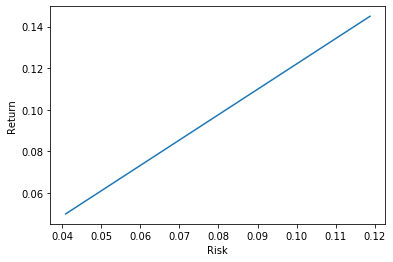

In [20]:
EffX=[]
EffY=[]
for i1 in range(0,20):
    robj=i1*0.005+0.05
    Ysig=Optimizer(robj,R,CovMatrix)[1]
    EffX.append(robj)
    EffY.append(Ysig)
plt.xlabel("Risk")
plt.ylabel("Return")
plt.plot(EffY,EffX)
plt.show

In [21]:
(EffY[5]-EffY[0])/(EffX[5]-EffX[0])

0.818879049256635

In [22]:
(EffY[19]-EffY[14])/(EffX[19]-EffX[14])

0.8188790492566353

So there is a curvature (very small...) ! Let's look at composition, for example at Return=0.1

In [23]:
Optimizer(0.1,R,CovMatrix)

[array([ 0.10226656,  0.57721633, -0.15956475]), 0.08188790492566353]

Uhm... we can go short in this example... let us assume not. Let's put in positive weights and full investment constraints.
Of course, we shall go to numeric optimization, but in this case (only three assets) it's not difficult...

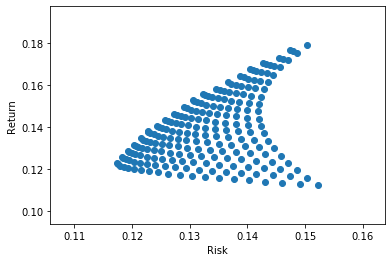

In [24]:
PtfX=[]
PtfY=[]
for i1 in range(0,20):
    for i2 in range(0,20):
        w1=i1*0.05
        w2=i2*0.05
        w3=1-w1-w2
        if (w3>=0):
            Xrend=np.dot([w1,w2,w3],R)
            Ysig=np.dot([w1,w2,w3],np.dot([w1,w2,w3],CovMatrix))**0.5
            PtfX.append(Xrend)
            PtfY.append(Ysig)
            
plt.scatter(PtfY,PtfX)
plt.xlabel("Risk")
plt.ylabel("Return")
plt.show()
        

Now curvature is much more visible. Let us draw the sharpe index. We will assume a risk free rate of -0.006755

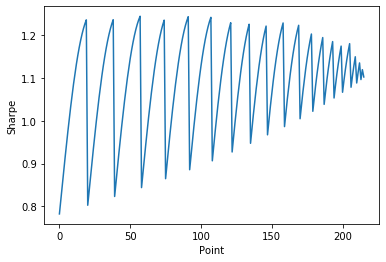

In [25]:
Sharpe=[]
for i in range(0,len(PtfX)):
    Sharpe.append((PtfX[i]+0.006755)/PtfY[i])
plt.xlabel("Point")
plt.ylabel("Sharpe")
plt.plot(Sharpe)
plt.show()

In [26]:
max(Sharpe)

1.2442331796027273

In [27]:
Sharpe.index(max(Sharpe))

57

In [28]:
PtfX[57]

0.1765516478257097

In [29]:
PtfY[57]

0.14732499569271887

The optimal market porfolio has a return of 17.65% and a volatility of 14.73%
Lets draw che CAPM line...

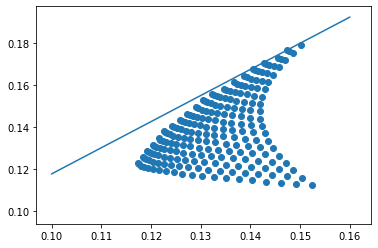

In [30]:
plt.scatter(PtfY,PtfX)
plt.plot([0.1,0.16],[-0.006755+1.24423318*0.1,-0.006755+1.24423318*0.16])
plt.show()

Let's look at diversification...

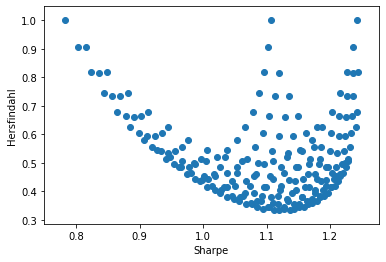

In [31]:
PtfX=[]
PtfY=[]
for i1 in range(0,21):
    for i2 in range(0,21):
        w1=i1*0.05
        w2=i2*0.05
        w3=1-w1-w2
        if (w3>=0):
            YH=(w1*w1+w2*w2+w3*w3)
            Xsharpe=(np.dot([w1,w2,w3],R)+0.006755)/np.dot([w1,w2,w3],np.dot([w1,w2,w3],CovMatrix))**0.5
            PtfX.append(Xsharpe)
            PtfY.append(YH)
            
plt.scatter(PtfX,PtfY)
plt.xlabel("Sharpe")
plt.ylabel("Hersfindahl")
plt.show()

In particulare we see that

In [32]:
PtfY[57]

0.7350000000000001

In [33]:
PtfX[57]

1.235845440448274

An H index of 0.735 is very high... 

We created an efficient frontier, both using lagrangian and numerical approaches. We noticed that the optimal portfolios are quite concentrated. This is an aspect that lead to instability in practical applications. Let's look inside it:

In [34]:
W1_Data=[]
BestPtd=Optimizer(0.1765,R,CovMatrix)
for i in range(1000):
    Errors=np.random.uniform(size=3)*0.1+0.95
    CovM2=np.ones((3,3))
    CovM2[0,1]=CovM2[1,0]=Errors[0]
    CovM2[0,2]=CovM2[2,0]=Errors[1]
    CovM2[1,2]=CovM2[2,1]=Errors[2]
    for j in range(3):
        for k in range(3):
            CovM2[j,k]=CovMatrix[j,k]*CovM2[j,k]
    CurrentPtd=Optimizer(0.1765,R,CovM2)
    CurrentW=CurrentPtd[0][0]
    W1_Data.append(CurrentW)

In [35]:
BestPtd

[array([ 0.18050047,  1.01878682, -0.28163178]), 0.14453215219379612]

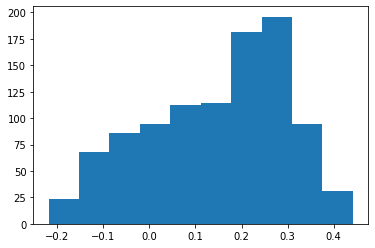

In [36]:
plt.hist(W1_Data)
plt.show()

Wow... with a central investment weight of about 20%, if we have a 5% error on correlation we can have to invest from -20% to +40% on the first asset...
Let's look at leverage:

In [37]:
L_Data=[]
BestPtd=Optimizer(0.1765,R,CovMatrix)
for i in range(1000):
    Errors=np.random.uniform(size=3)*0.1+0.95
    CovM2=np.ones((3,3))
    CovM2[0,1]=CovM2[1,0]=Errors[0]
    CovM2[0,2]=CovM2[2,0]=Errors[1]
    CovM2[1,2]=CovM2[2,1]=Errors[2]
    for j in range(3):
        for k in range(3):
            CovM2[j,k]=CovMatrix[j,k]*CovM2[j,k]
    CurrentPtd=Optimizer(0.1765,R,CovM2)
    CurrentL=CurrentPtd[0][0]+CurrentPtd[0][1]+CurrentPtd[0][2]
    L_Data.append(CurrentL)

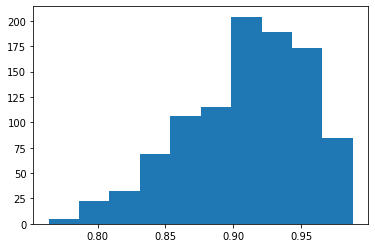

In [39]:
plt.hist(L_Data)
plt.show()

Lot of instability here too.

## Conclusion
Markowitz approach leads to efficient but concentrated and unstable portfolios. Unfortunately instability arises in normal applications due to uncertainty in future returns and, regarding covariance matrix, because of statistical error on estimations.
To address these problems different approaches were developed, like Black-Litterman and Bootstrapping techniques.